In [1]:
import sys, os
#restrict gpu usage
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch, torchvision
print('PyTorch version:          ', torch.__version__)
import pytorch_lightning as pl
print('PyTorch Lightning version:', pl.__version__)

import glob, tempfile
from pylab import *
import dataset, detector, util, evaluation

import PIL
PIL.Image.MAX_IMAGE_PIXELS = None #Needed to open large images

import warnings
warnings.simplefilter("ignore")

PyTorch version:           1.6.0+cu101
PyTorch Lightning version: 1.0.6


***
**Data collection**

In [2]:
IMAGEFILES    = sorted(glob.glob('data/oak/train/*.jpg', recursive=True))
LABELFILES    = sorted(glob.glob('data/oak/train/*.png', recursive=True))

print(f'Found {len(IMAGEFILES)} images and {len(LABELFILES)} annotations')
assert len(IMAGEFILES) == len(LABELFILES)

Found 20 images and 20 annotations


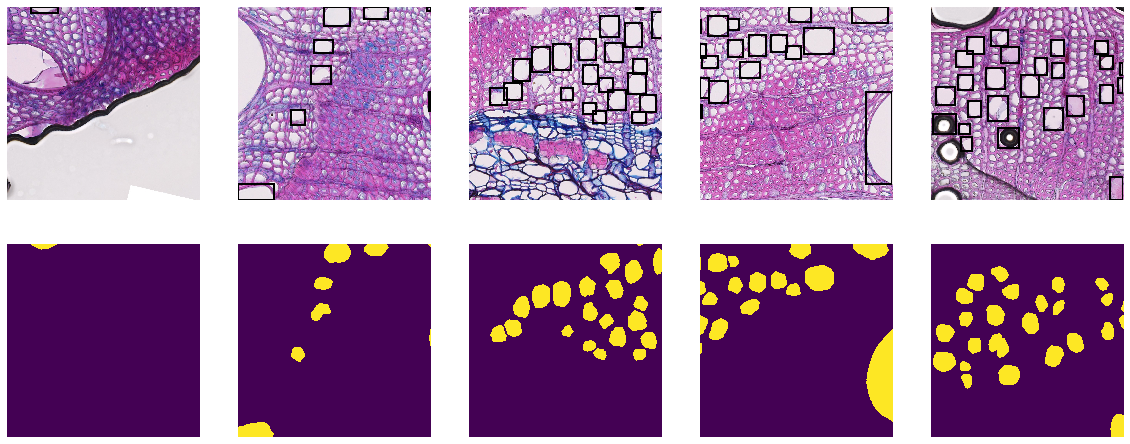

In [3]:
#example images with small vessels only
ds_small = dataset.Dataset(IMAGEFILES, LABELFILES, patchsize=1000, augment=True, preprocess_mask_fn=dataset.remove_large_vessels)

figure(0, (20,8))
for i in range(5):
    j     = np.random.randint(len(ds_small))
    a0,b0 = ds_small[j]
    subplot(2,5,i+1);   imshow(a0.transpose(1,2,0)); axis('off'); 
    [util.draw_box(b.numpy(), color='k', linewidth=2) for b in b0['boxes'] ];
    if len(b0['masks']):
        subplot(2,5,i+1+5); imshow(b0['masks'].max(0)[0].numpy()); axis('off');

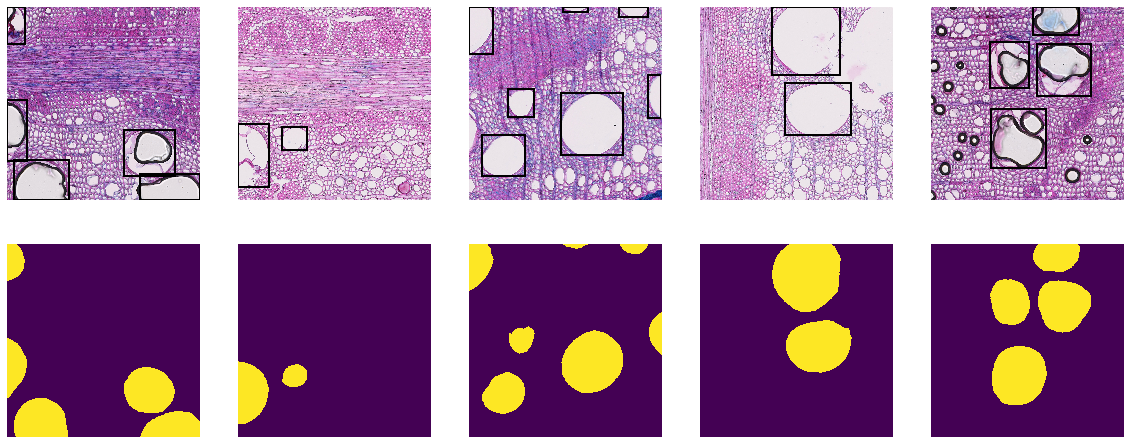

In [4]:
#example images with large vessels only
ds_large = dataset.Dataset(IMAGEFILES, LABELFILES, patchsize=2000, augment=True, preprocess_mask_fn=dataset.remove_small_vessels)

figure(0, (20,8))
for i in range(5):
    j     = np.random.randint(len(ds_large))
    a0,b0 = ds_large[j]
    subplot(2,5,i+1);   imshow(a0.transpose(1,2,0)); axis('off'); 
    [util.draw_box(b.numpy(), color='k', linewidth=2) for b in b0['boxes'] ];
    if len(b0['masks']):
        subplot(2,5,i+1+5); imshow(b0['masks'].max(0)[0].numpy()); axis('off');

***
**Training**

In [5]:
PATCHSIZES     = [1000, 2000]
preprocess_fns = [dataset.remove_large_vessels, dataset.remove_small_vessels]
models         = []

for patchsize, pre_fn in zip(PATCHSIZES, preprocess_fns):
    ds_train     = dataset.Dataset(IMAGEFILES, LABELFILES, patchsize, pre_fn, augment=True)
    loader_train = dataset.create_dataloader(ds_train, shuffle=True, batchsize=1)
    
    basemodel = detector.create_basemodel()
    trainer   = detector.create_trainer(epochs=20)
    trainer.fit(detector.TrainingModel(basemodel), loader_train)
    models.append( basemodel.cpu().eval() )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | basemodel | MaskRCNN | 44 M  


[0000] loss:  1.75400 | loss_classifier_step:  0.09611 | loss_box_reg_step:  0.14476 | loss_mask_step:  0.13113 | loss_objectness_step:  0.05109 | loss_rpn_box_reg_step:  0.00807 | loss_classifier_epoch:  0.78798 | loss_box_reg_epoch:  0.17110 | loss_mask_epoch:  0.28809 | loss_objectness_epoch:  0.47618 | loss_rpn_box_reg_epoch:  0.03051
[0001] loss:  0.48400 | loss_classifier_step:  0.15922 | loss_box_reg_step:  0.20869 | loss_mask_step:  0.09310 | loss_objectness_step:  0.02922 | loss_rpn_box_reg_step:  0.02302 | loss_classifier_epoch:  0.11715 | loss_box_reg_epoch:  0.14520 | loss_mask_epoch:  0.10992 | loss_objectness_epoch:  0.06886 | loss_rpn_box_reg_epoch:  0.04294
[0002] loss:  0.48900 | loss_classifier_step:  0.27411 | loss_box_reg_step:  0.27372 | loss_mask_step:  0.21444 | loss_objectness_step:  0.02369 | loss_rpn_box_reg_step:  0.02657 | loss_classifier_epoch:  0.12210 | loss_box_reg_epoch:  0.15544 | loss_mask_epoch:  0.14695 | loss_objectness_epoch:  0.04352 | loss_rpn_b

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | basemodel | MaskRCNN | 44 M  


[0000] loss:  1.18000 | loss_classifier_step:  0.16993 | loss_box_reg_step:  0.21592 | loss_mask_step:  0.10418 | loss_objectness_step:  0.02844 | loss_rpn_box_reg_step:  0.00907 | loss_classifier_epoch:  0.51502 | loss_box_reg_epoch:  0.16867 | loss_mask_epoch:  0.33928 | loss_objectness_epoch:  0.13035 | loss_rpn_box_reg_epoch:  0.02702
[0001] loss:  0.40500 | loss_classifier_step:  0.09984 | loss_box_reg_step:  0.18018 | loss_mask_step:  0.11586 | loss_objectness_step:  0.00940 | loss_rpn_box_reg_step:  0.02935 | loss_classifier_epoch:  0.09069 | loss_box_reg_epoch:  0.11616 | loss_mask_epoch:  0.11254 | loss_objectness_epoch:  0.06895 | loss_rpn_box_reg_epoch:  0.01712
[0002] loss:  0.35200 | loss_classifier_step:  0.13713 | loss_box_reg_step:  0.01832 | loss_mask_step:  0.09744 | loss_objectness_step:  0.00231 | loss_rpn_box_reg_step:  0.00013 | loss_classifier_epoch:  0.06177 | loss_box_reg_epoch:  0.11421 | loss_mask_epoch:  0.12545 | loss_objectness_epoch:  0.04144 | loss_rpn_b

***
**Inference**

In [6]:
full_model = detector.FullDetector(models, PATCHSIZES, slacks=[128,256])
#or load saved model
#import pickle
#full_model = pickle.load(open('model.pkl','rb'))

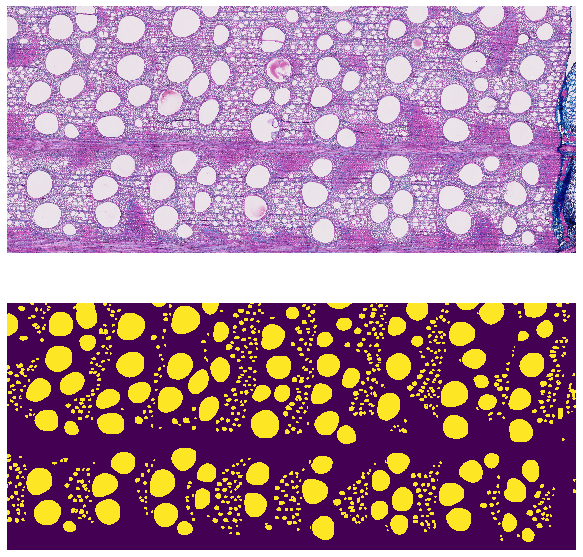

In [7]:
VALIDATION_IMAGE = 'data/oak/val/ELD_QURO_635A_1.jpg'

image   = full_model.load_image(VALIDATION_IMAGE)
output  = full_model.process_image(image, progress_callback=lambda x:print(f'Progress: {x*100:.1f}%', end='\r'))

figure(0, (16,10))
subplot(211);
imshow(np.rot90(image)); axis('off');
subplot(212);
imshow(np.rot90(output.squeeze())); axis('off');

***

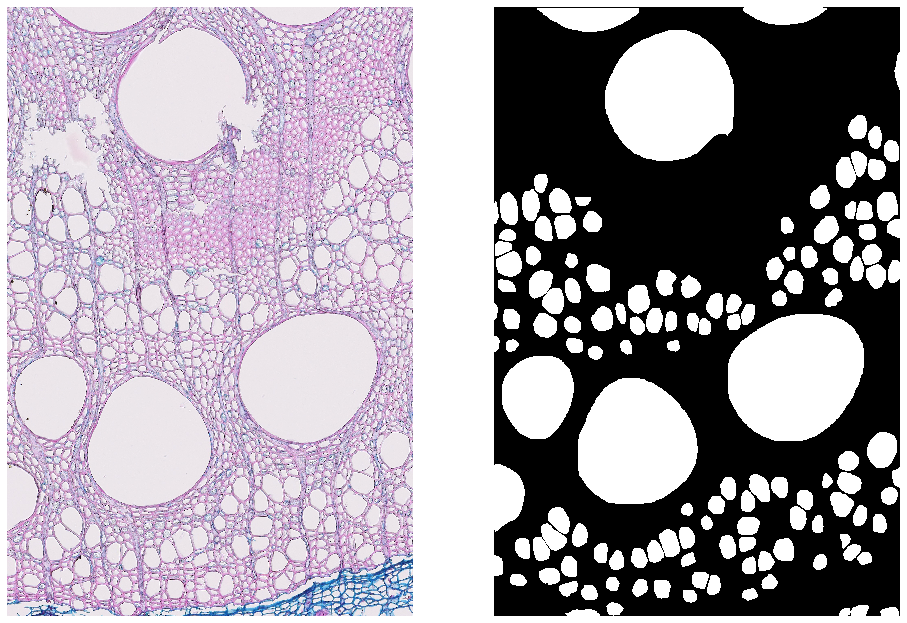

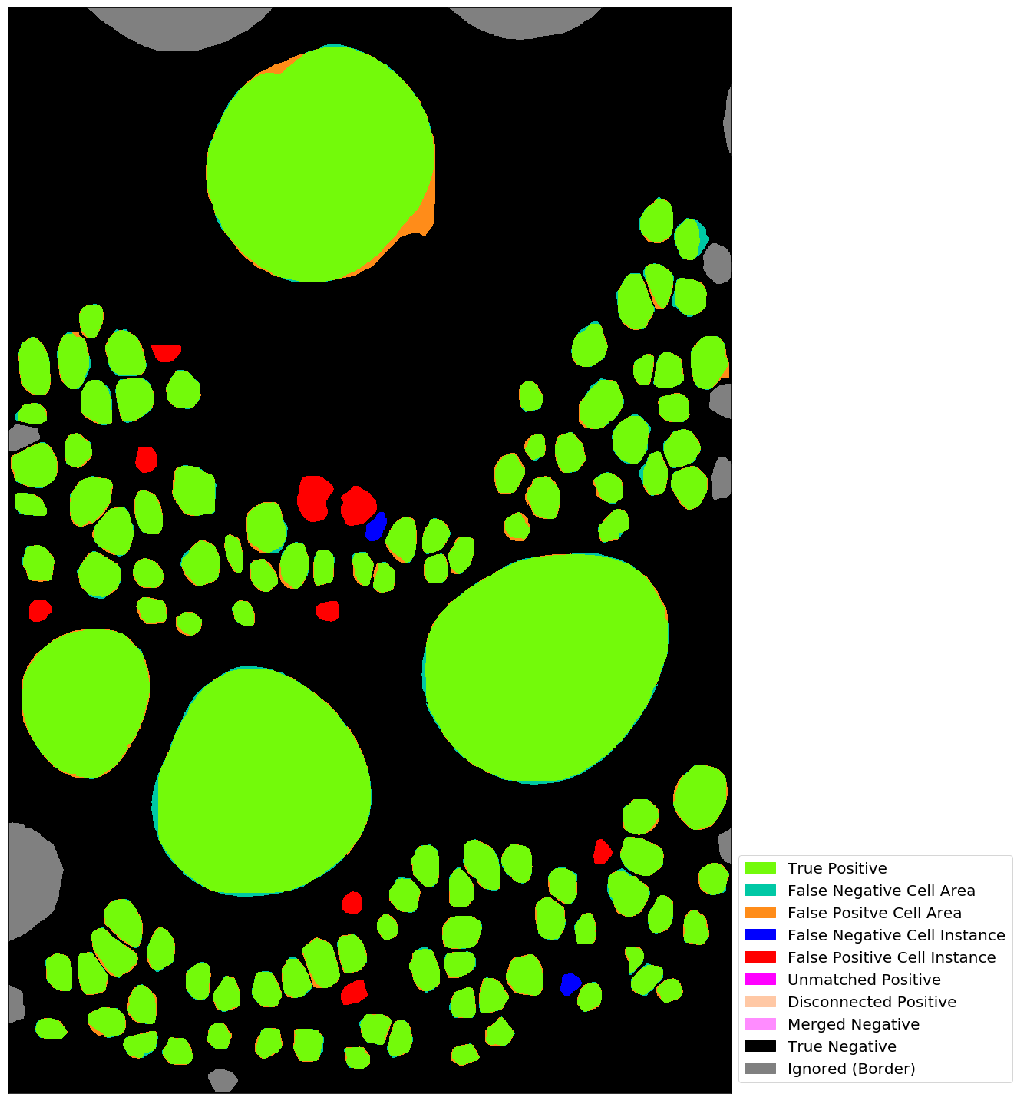

In [15]:
image         = full_model.load_image('data/oak/val/ELD_QURO_302A_1_0014.jpg')
output        = full_model.process_image(image, progress_callback=lambda x:print(f'Progress: {x*100:.1f}%', end='\r'))
gt            = PIL.Image.open('data/oak/val/ELD_QURO_302A_1_0014_AN.png').convert('L') / np.float32(255)
vismap, stats = evaluation.compare_to_groundtruth(gt, output, ignore_buffer_px=4)

figure(0, (16,16))
subplot(121); imshow(image); axis('off');
subplot(122); imshow(output, cmap=cm.gray); axis('off');

figure(1, (20,20))
imshow(vismap); axis('off');

In [9]:
print('Evaluation statistics:')
print(stats[0])
print('\nFalse positives:')
print(stats[1])

Evaluation statistics:
#cell centroid position (y x), prediction centroid position (y x), cell area, prediction area, true positive area, false positive area, false negative area, F1 score
(434.7 861.5), (439.1 868.4), 307970, 320519, 306438, 14081, 1532, 0.975158
(591.4 1792.7), (593.0 1793.1), 8677, 8842, 8459, 383, 218, 0.965694
(640.8 1884.8), (642.2 1877.1), 8003, 6125, 6121, 4, 1882, 0.866506
(762.3 1798.7), (766.7 1798.5), 6730, 7182, 6547, 635, 183, 0.941202
(816.1 1729.7), (816.9 1730.3), 11720, 11747, 11488, 259, 232, 0.979077
(800.6 1881.2), (799.5 1884.0), 7908, 7536, 7406, 130, 502, 0.959078
(864.9 230.1), (865.8 229.9), 4876, 5097, 4837, 260, 39, 0.970019
(935.6 1605.7), (937.5 1605.8), 9104, 8819, 8686, 133, 418, 0.969257
(959.5 324.5), (958.3 324.8), 11162, 11016, 10778, 238, 384, 0.971954
(976.8 180.8), (975.2 180.0), 10853, 10946, 10473, 473, 380, 0.960870
(980.2 1933.7), (981.2 1936.1), 11650, 12354, 11533, 821, 117, 0.960923
(993.6 73.4), (994.8 73.2), 11228, 11625,

***

In [ ]:
#optionally save the model
#import pickle
#open('model.pkl','wb').write( pickle.dumps(full_model) )